In [45]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('iris.csv')
data.head()


,5.1,3.5,1.4,.2,Setosa
0,4.9,3.0,1.4,0.2,Setosa
1,4.7,3.2,1.3,0.2,Setosa
2,4.6,3.1,1.5,0.2,Setosa
3,5.0,3.6,1.4,0.2,Setosa
4,5.4,3.9,1.7,0.4,Setosa


## **Step 1: Separate By Class**
 

*  we will first need to separate our training data by class
*   We can create a dictionary object where each key is the class value and then add a list of all the records as the value in the dictionary.

Below is a function named separate_by_class() that implements this approach. It assumes that the last column in each row is the class value.

In [60]:
def separate_by_class(dataset):
	separated_classes = dict()
	for i in range(len(dataset)):
		vector = dataset[i]
		class_value = vector[-1]
		if (class_value not in separated_classes):
			separated_classes[class_value] = list()
		separated_classes[class_value].append(vector)
	return separated_classes

## **Step 2: Summarize Dataset**
We need two statistics from a given set of data.

The two statistics we require from a given dataset are

*    The mean 
*   The standard deviation (average deviation from the mean).


You can use numpy library to calculate mean and standard devistion if you want

In [59]:
# Calculate the mean of a list of numbers
def mean(numbers):
	return sum(numbers)/float(len(numbers))
 
# Calculate the standard deviation of a list of numbers
def stdev(numbers):
	avg = mean(numbers)
	variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
	return sqrt(variance)
 
# Calculate the mean, stdev and count for each column in a dataset
def summarize_dataset(dataset):
	summaries = [(mean(column), stdev(column), len(column)) for column in zip(*dataset)]
	del(summaries[-1])
	return summaries

## **Step 3: Summarize Data By Class**
We require statistics from our training dataset organized by class.

*   Above, we have developed the separate_by_class() function to separate a dataset into rows by class.
*   And we have developed summarize_dataset() function to calculate summary statistics for each column.

We can put all of this together and summarize the columns in the dataset organized by class values.

Below is a function named summarize_by_class() that implements this operation. The dataset is first split by class, then statistics are calculated on each subset. The results in the form of a list of tuples of statistics are then stored in a dictionary by their class value.

In [61]:
def summarize_by_class(dataset):
	separated = separate_by_class(dataset)
	summaries = dict()
	for class_value, rows in separated.items():
		summaries[class_value] = summarize_dataset(rows)
	return summaries
 

## **Step 4: Gaussian Probability Density Function**
Calculating the probability or likelihood of observing a given real-value like X1 is difficult.

One way we can do this is to assume that X1 values are drawn from a distribution, such as a bell curve or Gaussian distribution.

A Gaussian distribution can be summarized using only two numbers: the mean and the standard deviation. Therefore, with a little math, we can estimate the probability of a given value. you can implement the guassian funcion or you can use numpy for this

In [ ]:
# Calculating the Gaussian probability distribution
def calculate_probability(x, mean, stdev):
	exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
	return (1 / (sqrt(2 * pi) * stdev)) * exponent
 

## **Step 5: Class Probabilities**
Now it is time to use the statistics calculated from our training data to calculate probabilities for new data.


*  Probabilities are calculated separately for each class. This means that we first calculate the probability that a new piece of data belongs to the first class, then calculate probabilities that it belongs to the second class, and so on for all the classes.The probability that a piece of data belongs to a class is calculated as follows: P(class|data) = P(X|class) * P(class)


Below is a function named calculate_class_probabilities() that ties all of this together.It takes a set of prepared summaries and a new row as input arguments.

1.   First the total number of training records is calculated from the counts stored in the summary statistics. This is used in the calculation of the probability of a given class or P(class) as the ratio of rows with a given class of all rows in the training data.
2.   Next, probabilities are calculated for each input value in the row using the Gaussian probability density function and the statistics for that column and of that class. Probabilities are multiplied together as they accumulated.


This process is repeated for each class in the dataset.

Finally a dictionary of probabilities is returned with one entry for each class.



In [62]:


def calculate_class_probabilities(summaries, row):
	total_rows = sum([summaries[label][0][2] for label in summaries])
	probabilities = dict()
	for class_value, class_summaries in summaries.items():
		probabilities[class_value] = summaries[class_value][0][2]/float(total_rows)
		for i in range(len(class_summaries)):
			mean, stdev, _ = class_summaries[i]
			probabilities[class_value] *= calculate_probability(row[i], mean, stdev)
	return probabilities
 
# Predict the class for any row
def predict(summaries, row):
	probabilities = calculate_class_probabilities(summaries, row)
	best_label, best_prob = None, -1
	for class_value, probability in probabilities.items():
		if best_label is None or probability > best_prob:
			best_prob = probability
			best_label = class_value
	return best_label

In [67]:
from csv import reader
from random import seed,randrange
from math import sqrt,exp,pi

# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset
 
# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())
 
# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup
 
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for _ in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split
 
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0
 
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores
 

 
# Naive Bayes Algorithm
def naive_bayes(train, test):
	summarize = summarize_by_class(train)
	predictions = list()
	for row in test:
		output = predict(summarize, row)
		predictions.append(output)
	return(predictions)
 
# Test Naive Bayes classifier on the Iris Dataset

seed(1)
dataset = load_csv('iris.csv')
for i in range(len(dataset[0])-1):
	str_column_to_float(dataset, i)
 
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)

# evaluate algorithm
n_folds = 10
scores = evaluate_algorithm(dataset, naive_bayes, n_folds)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [86.66666666666667, 100.0, 93.33333333333333, 100.0, 100.0, 100.0, 100.0, 86.66666666666667, 86.66666666666667, 100.0]
Mean Accuracy: 95.333%


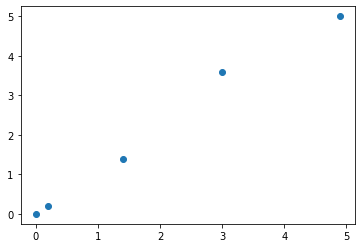

In [70]:
plt.scatter(dataset[1],dataset[4],cmap='spectral')